In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from scipy.stats import median_abs_deviation as MAD
from scipy.optimize import fsolve
sns.set()

In [2]:
n_samples = 1000
n_outliers = 50
X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1, n_informative=1, noise=10, coef=True, random_state=0)

# Add outliers
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)
X = X.reshape(1,1000)[0]
data = pd.DataFrame(columns=['x', 'y'])
data['x'] = X
data['y'] = y

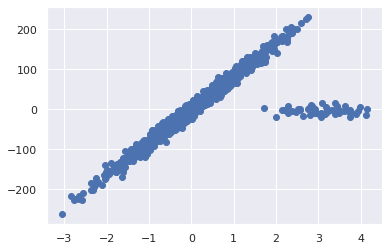

In [3]:
plt.scatter(X,y)
plt.show()

In [26]:
def IRLS(X, y, k):
    
    def WLS(beta, weight):
        return (weight*(y-beta*X)*X).sum()
    
    def Huber_weight(derivative, resid):
        return np.where(resid==0, 0, derivative/resid)

    def Huber_derivative(X, k):
        return 2 * np.where(np.abs(X)<=k, X, k*np.sign(X))
    
    initial = sm.OLS(y, X).fit()
    scale_old = MAD(initial.resid)
    weight_new = Huber_weight(Huber_derivative(initial.resid/scale_old, k), initial.resid)
        
    thres = 1e-8
    
    while True:
        beta_new = fsolve(WLS, 1, args=(weight_new,))
        resid_new = y-beta_new*X
        scale_new = MAD(resid_new)
        derivative = Huber_derivative(resid_new/scale_new, k)
        weight_new = Huber_weight(derivative, resid_new)
        if abs(scale_new - scale_old) <= thres:
            return beta_new, weight_new
        scale_old = scale_new

In [27]:
ols_model = sm.OLS(y, X).fit()
huber_beta, huber_weight = IRLS(X, y, k=0.97)

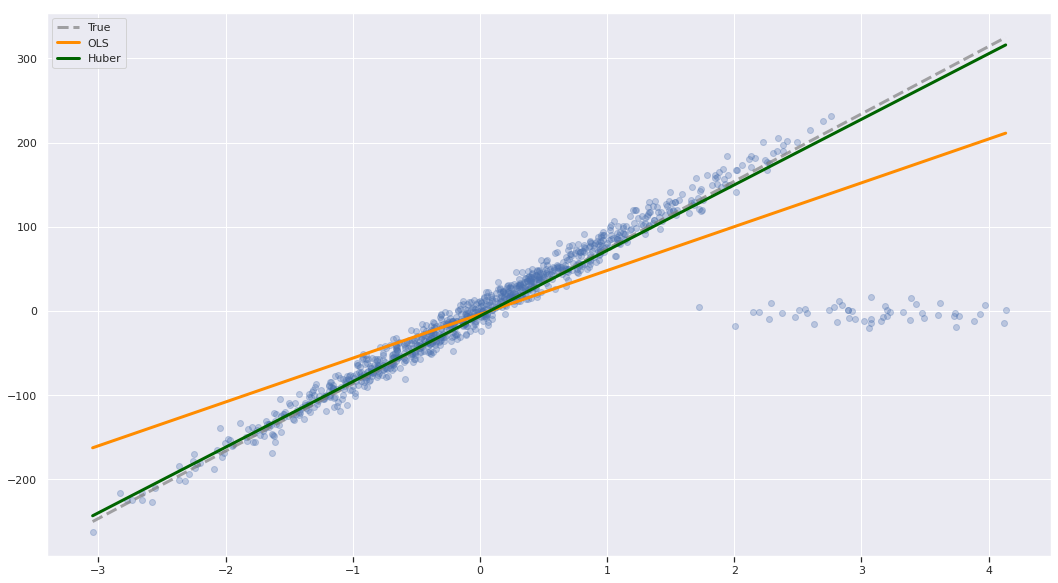

In [28]:
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y_OLS = ols_model.predict(line_X)
line_y_Huber = huber_beta * line_X
line_true = coef * line_X
fig, ax1 = plt.subplots(figsize=(18,10))
ax1.scatter(X,y, alpha=0.3)

ax2=ax1.twiny()
ax2.plot(line_X, line_true, '--', linewidth=3, color='grey', alpha=0.7)
ax2.plot(line_X, line_y_OLS, linewidth=3, color='darkorange')
ax2.plot(line_X, line_y_Huber, linewidth=3, color='darkgreen')
ax2.get_xaxis().set_visible(False)

ax2.legend(["True", "OLS", "Huber"])
plt.show()

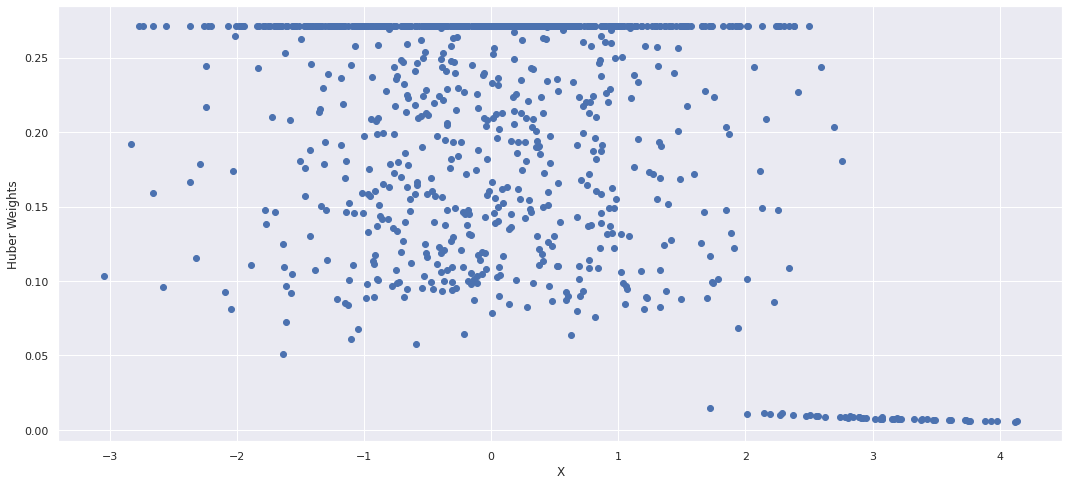

In [29]:
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(X,huber_weight)
ax.set_xlabel("X")
ax.set_ylabel("Huber Weights")
plt.show()

## statsmodels implementation

In [8]:
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT(t=0.97)).fit()

In [9]:
print(rlm_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 1000
Model:                            RLM   Df Residuals:                      999
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 13 May 2021                                         
Time:                        10:29:09                                         
No. Iterations:                    24                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            79.6427      0.302    263.320      0.0

In [10]:
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.636
Model:                            OLS   Adj. R-squared (uncentered):              0.636
Method:                 Least Squares   F-statistic:                              1748.
Date:                Thu, 13 May 2021   Prob (F-statistic):                   1.21e-221
Time:                        10:29:09   Log-Likelihood:                         -5290.2
No. Observations:                1000   AIC:                                  1.058e+04
Df Residuals:                     999   BIC:                                  1.059e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

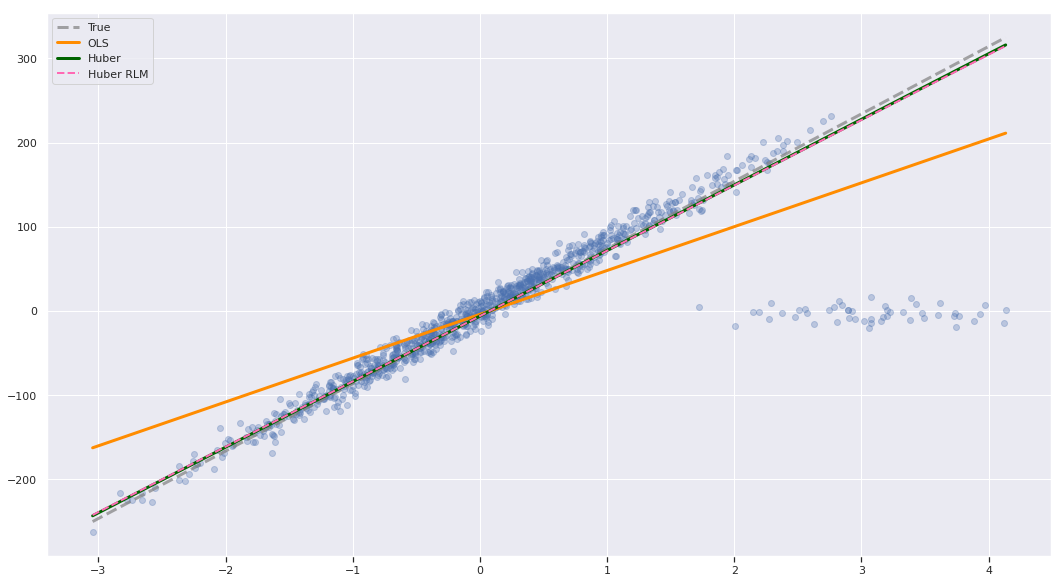

In [11]:
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y_OLS = ols_model.predict(line_X)
line_y_Huber = huber_beta * line_X
line_y_Huber_rlm = rlm_model.params * line_X
line_true = coef * line_X
fig, ax1 = plt.subplots(figsize=(18,10))
ax1.scatter(X,y, alpha=0.3)

ax2=ax1.twiny()
ax2.plot(line_X, line_true, '--', linewidth=3, color='grey', alpha=0.7)
ax2.plot(line_X, line_y_OLS, linewidth=3, color='darkorange')
ax2.plot(line_X, line_y_Huber, linewidth=3, color='darkgreen')
ax2.plot(line_X, line_y_Huber_rlm, '--', linewidth=2, color='hotpink')
ax2.get_xaxis().set_visible(False)

ax2.legend(["True", "OLS", "Huber", "Huber RLM"])
plt.show()

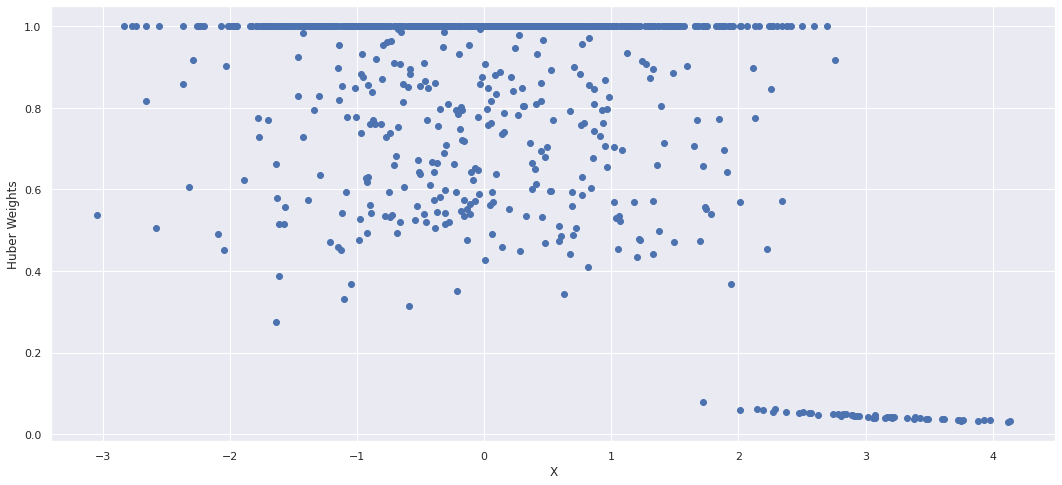

In [34]:
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(X,rlm_model.weights)
ax.set_xlabel("X")
ax.set_ylabel("Huber Weights")
plt.show()

### Comparison of Weights

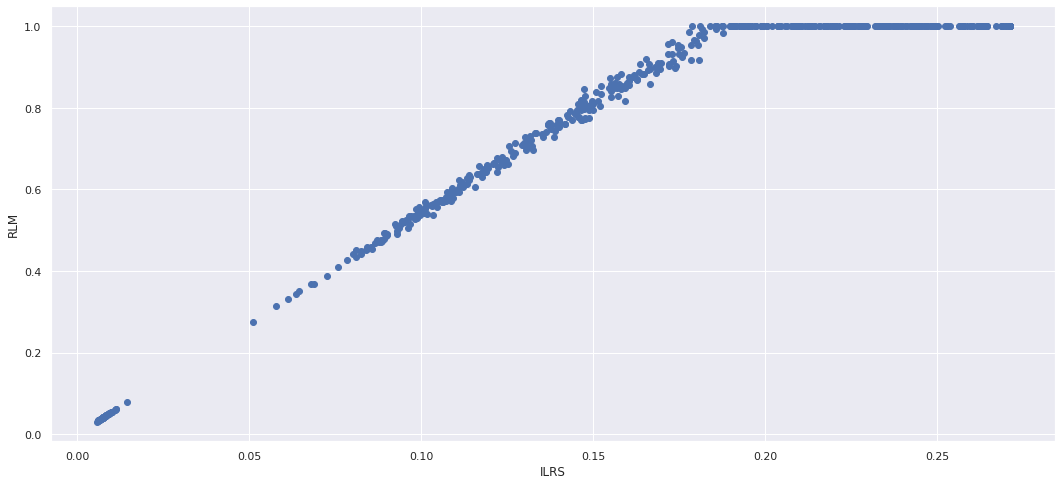

In [36]:
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(huber_weight,rlm_model.weights)
ax.set_xlabel("ILRS")
ax.set_ylabel("RLM")
plt.show()

### statsmodels.robust.norms.HuberT

```python
class HuberT(RobustNorm):
    """
    Huber's T for M estimation.

    Parameters
    ----------
    t : float, optional
        The tuning constant for Huber's t function. The default value is
        1.345.

    See Also
    --------
    statsmodels.robust.norms.RobustNorm
    """

    def __init__(self, t=1.345):
        self.t = t

    def _subset(self, z):
        """
        Huber's T is defined piecewise over the range for z
        """
        z = np.asarray(z)
        return np.less_equal(np.abs(z), self.t)

    def rho(self, z):
        r"""
        The robust criterion function for Huber's t.

        Parameters
        ----------
        z : array_like
            1d array

        Returns
        -------
        rho : ndarray
            rho(z) = .5*z**2            for \|z\| <= t

            rho(z) = \|z\|*t - .5*t**2    for \|z\| > t
        """
        z = np.asarray(z)
        test = self._subset(z)
        return (test * 0.5 * z**2 +
                (1 - test) * (np.abs(z) * self.t - 0.5 * self.t**2))

    def psi(self, z):
        r"""
        The psi function for Huber's t estimator

        The analytic derivative of rho

        Parameters
        ----------
        z : array_like
            1d array

        Returns
        -------
        psi : ndarray
            psi(z) = z      for \|z\| <= t

            psi(z) = sign(z)*t for \|z\| > t
        """
        z = np.asarray(z)
        test = self._subset(z)
        return test * z + (1 - test) * self.t * np.sign(z)

    def weights(self, z):
        r"""
        Huber's t weighting function for the IRLS algorithm

        The psi function scaled by z

        Parameters
        ----------
        z : array_like
            1d array

        Returns
        -------
        weights : ndarray
            weights(z) = 1          for \|z\| <= t

            weights(z) = t/\|z\|      for \|z\| > t
        """
        z = np.asarray(z)
        test = self._subset(z)
        absz = np.abs(z)
        absz[test] = 1.0
        return test + (1 - test) * self.t / absz

    def psi_deriv(self, z):
        """
        The derivative of Huber's t psi function

        Notes
        -----
        Used to estimate the robust covariance matrix.
        """
        return np.less_equal(np.abs(z), self.t)
```
